# Extracting Files

In [ ]:
import zipfile
with zipfile.ZipFile("Grasp-and-Lift EEG Detection/test.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("Grasp-and-Lift EEG Detection/train.zip","r") as z:
    z.extractall(".")


# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_set_labels = pd.read_csv("train/subj1_series1_events.csv")
train_set_signals = pd.read_csv("train/subj1_series1_data.csv")

train_set_signals.head()
axis = plt.gca()
downSampleToShow = 500

# EEG Channels: Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
# Plotting some Channels (Features)
train_set_signals[::downSampleToShow].plot(x="id", y="Fp1", ax=axis)
train_set_signals[::downSampleToShow].plot(x="id", y="Fp2", ax=axis)
train_set_signals[::downSampleToShow].plot(x="id", y="PO10", ax=axis, figsize=(15,5))

# Events: HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
# Plotting Targets (Classes)
train_set_labels[::downSampleToShow].plot(figsize=(15,5))
plt.show()

# Showing Targets corisponding to Features

In [ ]:
eeg_channels = train_set_signals.columns.drop('id')
labels = train_set_labels.columns.drop(['id','FirstDigitTouch'])

train_set_complete = pd.concat([train_set_signals, train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))

train_set_complete.head()

def highlight(indices,ax,color):
    for i in range(len(indices)):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        
secondsToShow = 8
channelsToShow = 3
labelsToShow = 6

sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","purple", "pink", "blue", "green"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,10))

for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1
        
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sub1_events_file = 'train/subj1_series1_events.csv'
sub1_data_file = 'train/subj1_series1_data.csv'

sub1_events = pd.read_csv(sub1_events_file)
sub1_data = pd.read_csv(sub1_data_file)

sub1 = pd.concat([sub1_events, sub1_data], axis = 1)
sub1["time"] = range(0, len(sub1))

sample_sub1 = sub1[sub1["time"] < 8*500]

EventColors = {"BothReleased": "green", "BothStartLoadPhase": "blue", 'HandStart':'red', 'LiftOff': "pink", "Replace":"purple"}

plot_columns = ["O1", "O2", "C3", "C4"]

fig, axes = plt.subplots(nrows=len(plot_columns), ncols=1)

for (i, y) in enumerate(plot_columns):
    for event, color in EventColors.items():
        # Plot all the columns
        sample_sub1[sample_sub1[event] == 1].plot(kind="scatter", x="time", y=y, edgecolors='none', ax=axes[i], figsize=(10,8), color=color)
    axes[i].legend()
    
    axes[i].fill_between(sample_sub1["time"], sample_sub1[y], color='lightgrey', alpha=0.5)

plt.show()

# Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
import glob
from scipy import signal
import seaborn as sn

# Reading Training Data

In [3]:
#read csv file from the path
xpath = r'train' 
xfiles = glob.glob(xpath + "/*data.csv")
ypath = r'train' 
yfiles = glob.glob(ypath + "/*events.csv")

xli = []
yli = []

for f in xfiles:
    df = pd.read_csv(f, index_col=None, header=0)
    xli.append(df)

for f in yfiles:
    df = pd.read_csv(f, index_col=None, header=0)
    yli.append(df)
    
#concatatenate all the dataframes in the li
x_df = pd.concat(xli, axis=0, ignore_index=True)
x_df = x_df.iloc[:,1:]
x_data=x_df.values

y_df = pd.concat(yli, axis=0, ignore_index=True)
y_df = y_df.iloc[:,1:]
y_data=y_df.values

print(x_data.shape)
print(y_data.shape)


(119496, 32)
(119496, 6)


In [4]:
Xsc = StandardScaler().fit_transform(x_data)
Xsc=pd.DataFrame(Xsc)
y=pd.DataFrame(y_data)
Xsc.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.794134,-0.131257,-0.903003,-0.463655,0.471960,-1.934637,1.752789,-0.985319,-0.469411,1.134326,...,0.386875,0.900987,1.025592,-0.213575,0.959244,0.875635,0.760154,0.769698,0.205824,2.433033
1,-0.788785,-0.198203,-0.878923,-0.453854,0.549902,-1.099257,1.498176,-0.733902,-0.399023,1.198530,...,0.355357,0.762135,0.951825,-0.314675,0.983415,0.683016,0.513337,0.599590,0.061551,2.579445
2,-1.171230,-0.402229,-1.413490,-0.600867,0.549902,0.305083,1.239389,-0.980290,-0.671779,1.286810,...,0.274311,0.709240,0.878058,-0.359608,0.955216,1.021274,0.666363,0.599590,-0.020334,2.313242
3,-1.438674,-0.450048,-2.169590,-0.571464,0.450703,0.305083,1.149649,-1.075829,-0.539800,1.310886,...,0.319337,0.821643,0.883327,-0.340886,0.802133,1.110536,0.651554,0.588959,-0.035932,1.936122
4,-1.419953,-0.609443,-2.241828,-0.571464,0.075163,-0.286456,1.249824,-0.613222,-0.495807,1.190505,...,0.449911,0.742299,0.830636,-0.322164,0.717534,1.129329,0.695981,0.759066,-0.000838,1.887319


# Preprocessing

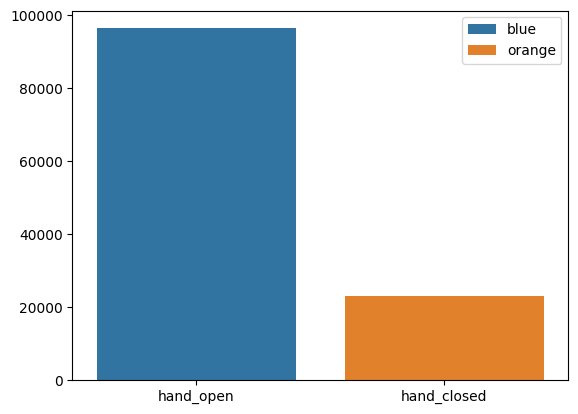

In [38]:
def edit_y(data_frame):
    data_frame = data_frame.drop(data_frame.columns[0], axis=1)
    data_frame['output'] = data_frame.apply(lambda x: 1 if 1 in x.values else 0, axis=1)
    y = data_frame['output']
    return y

y = edit_y(y_df)

labels = ['hand_open','hand_closed']

hand_closed = y[y.values == 1].shape[0]
hand_open = y[y.values == 0].shape[0]

colors = ['blue', 'orange']

sn.barplot(x=labels, y=[hand_open,hand_closed], hue=colors)
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(Xsc, y, test_size = 0.2, random_state = 0)


svc=SVC(class_weight='balanced') 
            
# Fit classifier to training set
svc.fit(X_train,y_train)

# Make predictions on test set - unseen daa
y_pred = svc.predict(X_test)

print(f'y predict = {y_pred}')
print(f'y test = {y_test}')

print(f'Accuracy score: {accuracy_score(y_test, y_pred):0.4f}')

# Confusion Matrix
cf_matrix = confusion_matrix(y_test,y_pred)
print(cf_matrix)

y predict = [0 0 0 ... 0 0 0]
y test = 1049      0
81838     0
114086    0
111552    0
53425     0
         ..
115944    0
105783    0
96782     0
31068     0
98951     0
Name: output, Length: 23900, dtype: int64
Accuracy score: 0.8118
[[15328  4024]
 [  475  4073]]


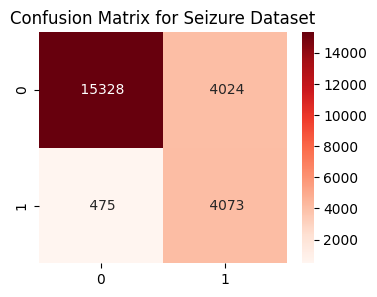

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     19352
           1       0.50      0.90      0.64      4548

    accuracy                           0.81     23900
   macro avg       0.74      0.84      0.76     23900
weighted avg       0.88      0.81      0.83     23900



In [41]:
from sklearn.metrics import classification_report
import joblib

plt.figure(figsize=(4,3))
plt.title('Confusion Matrix for Seizure Dataset')
sn.heatmap(cf_matrix, annot=True, fmt=' ', cmap='Reds')
plt.show()

print(classification_report(y_test, y_pred))

joblib.dump(svc, 'svm_model.pkl')

df = pd.concat([X_test,y_test], axis=1)
df.to_csv('test.csv', index=False)